# Exercise 4

**Group 5**:
- Elias Maria Bonasera (2149751)
- Alberto Casellato (2139206)
- Nicola Garbin (2156363)
- Francesco Pazzocco (2165861)

# 1) Model Complexity and parameters' tuning

## Default XGBClassifier performance

### Imports
In this cell, we import the necessary libraries to execute our training and analysis that are not alrready imported

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
from   tqdm import tqdm
import pickle


import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree

from sklearn.ensemble        import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network  import MLPClassifier
from sklearn.metrics         import accuracy_score
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import KFold

fraction = [i / 20 for i in range(1, 20)]          # fraction of training set

mycmap = "spring"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

plt.style.use(["science", "grid", "notebook"])

mycmap = "spring"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

Here we load and divide the data in training set and test set (rates 80%-20%)

In [2]:
dname="./DATA/"
str0="_XGB_25.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.80*N) 
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]

list_cross_acc=[]
list_cross_err=[]
list_test_split_acc=[]
list_test_split_err=[]
list_model_param = []

### K-Fold Cross-Validation
We perform a 5-fold cross-validation by splitting the dataset in 5.

In [5]:
def k_fold(model):
    kf = KFold(n_splits=20, shuffle=True, random_state=42)
    accuracies=[]

    for train_indx, test_indx in kf.split(x_train):
        x_train_k, x_test_k = x_train[train_indx], x_train[test_indx]
        y_train_k, y_test_k = y_train[train_indx], y_train[test_indx]
    
        model.fit(x_train_k, y_train_k)
        y_test_hat = model.predict(x_test_k)
    
        accuracy = np.sum(y_test_hat == y_test_k)/len(y_test_k)
        accuracies.append(accuracy)
    
    mean_accuracy = np.mean(accuracies)
    std_dev = np.std(accuracies)
    return mean_accuracy, std_dev

### Test-splitting

After training on one of the folds, we apply a splitting to the test set. This resampling approach helps estimate the accuracy's statistical reliability by computing mean and standard deviation over multiple iterations. Our goal of using this tecnique is to verify the robustness of both possible estimators.

##### Notes on Bernoulli Standard Error Calculation
For each test-splitting's accuracy, we computed its standard error using the Bernoulli formula $\sqrt{p(1-p)/N}$ where $p=1/m$ and $m$ is the total sections, to capture the inherent variability in binary outcomes. We then aggregated these results by calculating a weighted mean and weighted variance, providing a robust estimate of the model's generalization performance.

In [7]:
def test_split(model):
    n=10
    m=int(len(x_test)/n)
   
    test_accuracies_m=[]
    bern=((1/n)*(1-1/n)/np.sqrt(m))*np.ones(n)
    for i in range(n):
        i1=i*m
        i2=(i+1)*m
        x_test_m, y_test_m = x_test[i1:i2,:], y_test[i1:i2]
        y_test_m_hat = model.predict(x_test_m)
        accuracy_m = np.sum(y_test_m_hat == y_test_m)/len(y_test_m)
        test_accuracies_m.append(accuracy_m)

    weight_accuracy_test_m = np.average(test_accuracies_m, weights=bern)
    std_dev_test_m_weight = np.sqrt(1/np.sum(1/bern**2))
    return weight_accuracy_test_m, std_dev_test_m_weight
    

### Preliminar analysis
- **Overall Performance:** We evaluate an XGBoost classifier with default parameter values in order to measure the model’s accuracy. We first implement a k-fold cross-validation to get an estimate of the accuracy of the model during training. During the test-splitting process, the test set is split into 10 equal parts and accuracy is computed separately for each. A weighted average accuracy and its standard deviation are then calculated.

In [9]:
model_0 = XGBClassifier(objective='binary:logistic', importance_type='gain')
cross_acc_0, cross_err_0 = k_fold(model_0)
list_cross_acc.append(cross_acc_0)
list_cross_err.append(cross_err_0)
print(f"Cross Validation accuracy: {cross_acc_0:.3f} ± {cross_err_0:.3f}")

model_0.fit(x_train, y_train) 

test_split_acc_0, test_split_err_0 = test_split(model_0)

list_test_split_acc.append(test_split_acc_0)
list_test_split_err.append(test_split_err_0)
print(f"Test accuracy: {test_split_acc_0:.3f} ± {test_split_err_0:.3f}")

Cross Validation accuracy: 0.936 ± 0.017
Test accuracy: 0.922 ± 0.003


## GridSearch with CV for best hyperparameter selection
#### Method
We define a hyperparameter grid and use `GridSearchCV` to search for the best configuration for our XGBoost model. We explore different values for parameters such as `n_estimators`, `max_depth`, `learning_rate`, `gamma`, `reg_lambda`, and `reg_alpha`. The search is performed using both 5-fold cross-validation and test_splitting methods, and we aim to maximize the accuracy score.
##### First trial
We use a GridSearch with cross-validation to refine the hyperparameter selection, trying to look for the best hyperparameter set. We repeat this process three times for different parameter intervals, initially focusing on parameter intervals close to the default values,since they achieve a good performance, and later extending the search range. For each model, we obtain an estimate of the accuracy both during training (via cross-validation implemented in GridSearchCV) and on the test set, providing insight into the model's generalization performance.

In [13]:
param_grid_trial_1 = {
    'n_estimators': [90, 100, 110],  
    'max_depth': [5, 6, 7],  
    'learning_rate': [0.2, 0.3, 0.4],  
    'gamma': [0, 0.1, 0.2, 0.3],  
    'reg_lambda': [0.8, 1, 1.2], 
    'reg_alpha': [0, 0.1, 0.2, 0.3], 
}

model_1 = XGBClassifier(objective='binary:logistic', importance_type='gain')

grid_search_1 = GridSearchCV(model_1, param_grid_trial_1, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search_1.fit(x_train, y_train)

best_params_1 = grid_search_1.best_params_
cross_acc_1 = grid_search_1.best_score_
cross_err_1 = grid_search_1.cv_results_['std_test_score'][grid_search_1.best_index_]
list_cross_acc.append(cross_acc_1)
list_cross_err.append(cross_err_1)
list_model_param.append(best_params_1)
print("Best parameters found: ", best_params_1)
print(f"Cross validation accuracy: {cross_acc_1:.3f} ± {cross_err_1:.3f}")


best_model_1=grid_search_1.best_estimator_ 
test_split_acc_1, test_split_err_1 = test_split(best_model_1)
list_test_split_acc.append(test_split_acc_1)
list_test_split_err.append(test_split_err_1)
print(f"Test accuracy: {test_split_acc_1:.3f} ± {test_split_err_1:.3f}")

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best parameters found:  {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 110, 'reg_alpha': 0, 'reg_lambda': 1.2}
Cross validation accuracy: 0.935 ± 0.007
Test accuracy: 0.921 ± 0.003


Here we aim to assess whether the accuracy of a model with hyperparameter tuning via GridSearchCV is influenced by the stochastic nature of the model.

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Run number 1. Hyperparameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 110, 'reg_alpha': 0, 'reg_lambda': 1.2} 

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Run number 2. Hyperparameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 110, 'reg_alpha': 0, 'reg_lambda': 1.2} 

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Run number 3. Hyperparameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 110, 'reg_alpha': 0, 'reg_lambda': 1.2} 

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Run number 4. Hyperparameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 110, 'reg_alpha': 0, 'reg_lambda': 1.2} 

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Run number 5. Hyperparameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 110, 'reg_alpha':

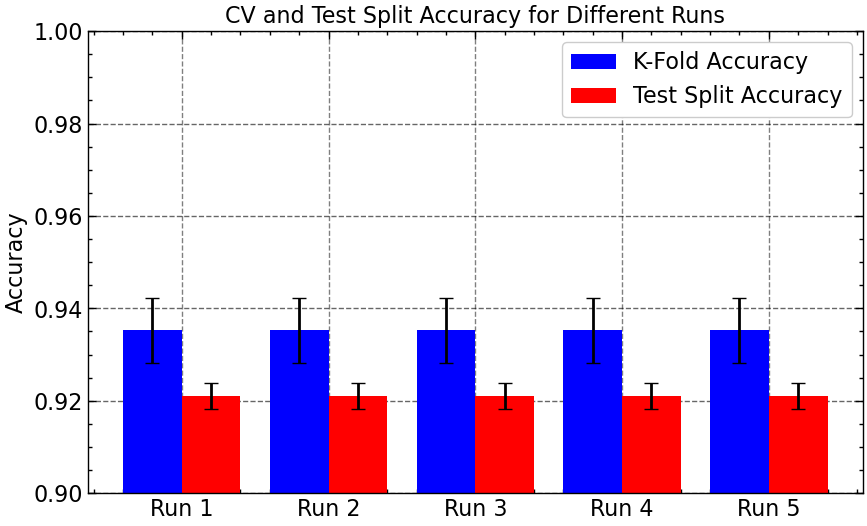

In [15]:
cross_acc_run = []
cross_err_run = []
test_split_acc_run = []
test_split_err_run = []

n=5
for i in range(5):
    
    param_grid_trial = {
    'n_estimators': [90, 100, 110],  
    'max_depth': [5, 6, 7],  
    'learning_rate': [0.2, 0.3, 0.4],  
    'gamma': [0, 0.1, 0.2, 0.3],  
    'reg_lambda': [0.8, 1, 1.2], 
    'reg_alpha': [0, 0.1, 0.2, 0.3], 
     }

    model = XGBClassifier(objective='binary:logistic', importance_type='gain')
    
    grid_search = GridSearchCV(model, param_grid_trial, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(x_train, y_train)
    
    best_params = grid_search.best_params_
    cross_acc = grid_search.best_score_
    cross_err = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
    
    best_model=grid_search_1.best_estimator_ 
    test_split_acc, test_split_err = test_split(best_model)
    print(f'Run number {i+1}. Hyperparameters: {best_params}', '\n')

    cross_acc_run.append(cross_acc)
    cross_err_run.append(cross_err)
    test_split_acc_run.append(test_split_acc)
    test_split_err_run.append(test_split_err)


runs = np.arange(n)  
bar_width = 0.4  
plt.figure(figsize=(10, 6))
plt.bar(runs - bar_width/2, cross_acc_run, yerr=cross_err_run, width=bar_width, label="K-Fold Accuracy", color="blue", capsize=5)
plt.bar(runs + bar_width/2, test_split_acc_run, yerr=test_split_err_run, width=bar_width, label="Test Split Accuracy", color="red", capsize=5)


plt.xticks(runs, [f"Run {i+1}" for i in runs])
plt.ylabel("Accuracy")
plt.ylim(.9,1)
plt.title("CV and Test Split Accuracy for Different Runs")
plt.legend()
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.show()

Bar plot showing the cross-validation and test split accuracy across 5 runs, with error bars representing the standard deviation. 
The identical results across all runs suggest that the process is stable and that model selection and accuracy are not affected by stochastic influence.
All the models have the exact same hyperparameters.

##### Second trial 

In [18]:
param_grid_trial_2 = {
    'n_estimators': [95, 100, 105],  
    'max_depth': [6, 7, 8],  
    'learning_rate': [0.25, 0.3, 0.35], 
    'gamma': [0, 0.05, 0.1], 
    'reg_lambda': [0.9, 1, 1.1],  
    'reg_alpha': [0, 0.05, 0.1]  
}
model_2 = XGBClassifier(objective='binary:logistic', importance_type='gain')

grid_search_2 = GridSearchCV(model_2, param_grid_trial_2, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search_2.fit(x_train, y_train)

best_params_2 = grid_search_2.best_params_
cross_acc_2 = grid_search_2.best_score_
cross_err_2 = grid_search_2.cv_results_['std_test_score'][grid_search_2.best_index_]
list_cross_acc.append(cross_acc_2)
list_cross_err.append(cross_err_2)
list_model_param.append(best_params_2)
print("Best parameters found: ", best_params_2)
print(f"Cross validation accuracy: {cross_acc_2:.3f} ± {cross_err_2:.3f}")


best_model_2=grid_search_2.best_estimator_ 
test_split_acc_2, test_split_err_2 = test_split(best_model_2)
list_test_split_acc.append(test_split_acc_2)
list_test_split_err.append(test_split_err_2)
print(f"Test accuracy: {test_split_acc_2:.3f} ± {test_split_err_2:.3f}")

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'gamma': 0, 'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 95, 'reg_alpha': 0.05, 'reg_lambda': 0.9}
Cross validation accuracy: 0.938 ± 0.007
Test accuracy: 0.933 ± 0.003


##### Third trial 

In [20]:
param_grid_trial_3 = {
    'n_estimators': [99, 100, 101],  
    'max_depth': [6, 7],  
    'learning_rate': [0.28, 0.3, 0.32], 
    'gamma': [0, 0.05, 0.1], 
    'reg_lambda': [0.05, 0.1, 0.15],  
    'reg_alpha': [0.9, 1, 1.1],  
}
model_3 = XGBClassifier(objective='binary:logistic', importance_type='gain')

grid_search_3 = GridSearchCV(model_3, param_grid_trial_3, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search_3.fit(x_train, y_train)

best_params_3 = grid_search_3.best_params_
cross_acc_3 = grid_search_3.best_score_
cross_err_3 = grid_search_3.cv_results_['std_test_score'][grid_search_3.best_index_]
list_cross_acc.append(cross_acc_3)
list_cross_err.append(cross_err_3)
list_model_param.append(best_params_3)
print("Best parameters found: ", best_params_3)
print(f"Cross validation accuracy: {cross_acc_3:.3f} ± {cross_err_3:.3f}")


best_model_3 = grid_search_3.best_estimator_ 
test_split_acc_3, test_split_err_3 = test_split(best_model_3)
list_test_split_acc.append(test_split_acc_3)
list_test_split_err.append(test_split_err_3)
print(f"Test accuracy: {test_split_acc_3:.3f} ± {test_split_err_3:.3f}")

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best parameters found:  {'gamma': 0, 'learning_rate': 0.28, 'max_depth': 7, 'n_estimators': 99, 'reg_alpha': 1, 'reg_lambda': 0.15}
Cross validation accuracy: 0.934 ± 0.009
Test accuracy: 0.938 ± 0.003


##### Fourth trial 

In [22]:
param_grid_trial_4 = {
    'n_estimators': [50, 150, 200],  
    'max_depth': [3, 10, 15],  
    'learning_rate': [0.05, 0.1, 0.5],  
    'gamma': [0, 0.5, 1],  
    'reg_lambda': [0.1, 1, 10],  
    'reg_alpha': [0, 0.5, 1]  
}
model_4 = XGBClassifier(objective='binary:logistic', importance_type='gain')

grid_search_4 = GridSearchCV(model_4, param_grid_trial_4, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search_4.fit(x_train, y_train)

best_params_4 = grid_search_4.best_params_
cross_acc_4 = grid_search_4.best_score_
cross_err_4 = grid_search_4.cv_results_['std_test_score'][grid_search_4.best_index_]
list_cross_acc.append(cross_acc_4)
list_cross_err.append(cross_err_4)
list_model_param.append(best_params_4)
print("Best parameters found: ", best_params_4)
print(f"Cross validation accuracy: {cross_acc_4:.3f} ± {cross_err_4:.3f}")


best_model_4 = grid_search_4.best_estimator_ 
test_split_acc_4, test_split_err_4 = test_split(best_model_4)
list_test_split_acc.append(test_split_acc_4)
list_test_split_err.append(test_split_err_4)
print(f"Test accuracy: {test_split_acc_4:.3f} ± {test_split_err_4:.3f}")

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 10}
Cross validation accuracy: 0.939 ± 0.013
Test accuracy: 0.935 ± 0.003


##### Visualization of the results

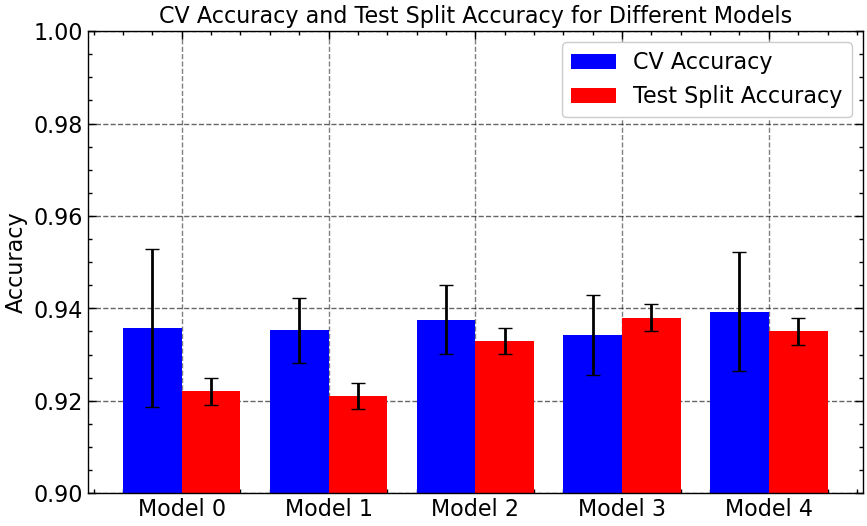

In [24]:
import numpy as np
import matplotlib.pyplot as plt


models = np.arange(len(list_cross_acc))  
bar_width = 0.4  
plt.figure(figsize=(10, 6))
plt.bar(models - bar_width/2, list_cross_acc, yerr=list_cross_err, width=bar_width, label="CV Accuracy", color="blue", capsize=5)
plt.bar(models + bar_width/2, list_test_split_acc, yerr=list_test_split_err, width=bar_width, label="Test Split Accuracy", color="red", capsize=5)


plt.xticks(models, [f"Model {i}" for i in models])
plt.ylabel("Accuracy")
plt.ylim(0.9,1)
plt.title("CV Accuracy and Test Split Accuracy for Different Models")
plt.legend()
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.show()

The bar plot compares the cross-validation accuracy (blue bars) and the test split accuracy (red bars) for the five different models, with error bars representing the standard deviation. This visualization shows both the stability of each model during training (via cross-validation) and its generalization performance on unseen data. Model 0 shows high variability and low performance; Models 1 and 2 improve stability and accuracy modestly; Models 3 and 4 deliver similar, high performance with Model 4 being the most robust, as its CV and test accuracies are nearly identical with minimal variance.

The simplest yet effective XGB model that maintains good validation accuracy appears to be Model 4, as it achieves stable cross-validation and test accuracy with relatively small error bars.

In [27]:
print(f'The hyperparameters of Model 4 are: {list_model_param[3]}')

The hyperparameters of Model 4 are: {'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 10}


Regarding regularization, reg_alpha (L1 regularization) and reg_lambda (L2 regularization) are both present, different from zero, in the optimal model, suggesting that some degree of regularization is beneficial for controlling overfitting.

## 2) Dimensionality reduction
### Method
Here we use the analysis tecnique implemented on section 1 to verify the effects on our trained model in reconigizing the pattern in a dataset with reduced features. In particular we are going to use the k-fold method since both test-splitting and k-fold has proved to be both reliable with similar precision. Features L2 and L3 are random noise, while L0 and L1 encode the patterns that XGBoost learns. We expect an improvement in performance if the noise in L2 and L3 is removed before the learning phase.

##### Notes
- Differences in accuracy will stem only from feature reduction, not hyperparameter changes
- we expect that `feature_imporance_` property ranks features by their contribution to the model. The least important feature(s) are excluded by dimensionality reduction.

In [34]:
# best XGBClassifier model obtained from random search
def XGBClassifier_maker():
    best_XGBClassifier = XGBClassifier(objective       = 'binary:logistic',
                                       importance_type = 'gain',
                                       gamma           = 0,
                                       learning_rate   = 0.28,
                                       max_depth       = 7,
                                       n_estimators    = 99,
                                       reg_alpha       = 1,
                                       reg_lambda      = 0.15,
                                       random_state    = 12345)
    ####################################
    #
    return best_XGBClassifier
#####

In [11]:
def split_dataset(i, x, dimensionality_reduction = 0):
    f = fraction[i]
    N_train = int(f * N) #75% training -> 25% test
    #
    if dimensionality_reduction   == 1:
        x_tmp = np.array([x[:,0], x[:,1], x[:,2]]).T
    elif dimensionality_reduction == 2:
        x_tmp = np.array([x[:,0], x[:,1]]).T
    elif dimensionality_reduction == 3:
        x_tmp = np.array([x[:,0]]).T
    else:
        x_tmp = x
    #####
    #
    x_train, y_train = x_tmp[:N_train], y[:N_train]
    x_test,  y_test  = x_tmp[N_train:], y[N_train:]
    return x_train, y_train, x_test, y_test
#####

plt.style.use(["science", "grid", "notebook"])

In [12]:
def accuracy_generator(mlp, scale = False, reduction = 0):
    def scaler(x_train, x_test):
        scaler = StandardScaler()
        x_tr   = scaler.fit_transform(x_train)
        x_te   = scaler.transform(x_test)
        return x_tr, x_te
    #####
    #
    def cross_validation(mlp, x_train, y_train, x_test, y_test):
        xsets = np.array(x_train)
        ysets = np.array(y_train)
        accuracies = []
        #
        for i in range(1, 11):
            x = xsets[(np.arange(len(xsets)) % 10) != i]
            y = ysets[(np.arange(len(xsets)) % 10) != i]
            mlp.fit(x, y)
            y_pred = mlp.predict(x_test)
            accuracies.append(accuracy_score(y_test, y_pred))
        #####
        #
        accuracies = np.array(accuracies)
        return accuracies.mean(), accuracies.std()
    #####
    #
    accuracies = []
    for i in tqdm(range(len(fraction))):
        x_train, y_train, x_test, y_test = split_dataset(i, x, dimensionality_reduction = reduction)
        if scale: x_train, x_test        = scaler(x_train, x_test)
        accuracies.append(cross_validation(mlp, x_train, y_train, x_test, y_test))
    #####
    accuracies = np.array(accuracies)
    #
    if str(mlp)[:3] == "MLP":
        accuracy_generator.MLP_accuracies.append(accuracies)
    elif str(mlp)[:3] == "XGB":
        accuracy_generator.XGB_accuracies.append(accuracies)
    else:
        print("'mlp' NOT supported")
    #####
#####

accuracy_generator.MLP_accuracies = []
accuracy_generator.XGB_accuracies = []

In [25]:
def make_plot(accuracies, title = "title", width = 2, lim = (5, 100), ths = None):
    double = (type(ths) != type(None))
    triple = accuracies.shape[0] == 3
    xdata  = np.array(fraction) * 100
    ydata  = accuracies * 100
    #
    plt.figure(figsize = (10, 6))
    if triple:
        ths = np.array(ths) * 100
        plt.fill_between(xdata, ths[0], ths[1], color = 'blue', alpha = 0.4)
        #
        plt.bar(xdata,
            ydata[0][:, 0],
            yerr    = ydata[0][:, 1],
            width   = width,
            capsize = 6,
            color   = 'red',
            alpha   = 0.9,
            label   = "L0+L1 (the significant ones)")
        #####
        ydata = ydata[-2:]
    #####
    #
    if double:
        if not triple: 
            ths = np.array(ths) * 100
            plt.fill_between(xdata, ths[0], ths[1], color = 'blue', alpha = 0.4)
        #####
        #
        plt.bar(xdata,
            ydata[0][:, 0],
            yerr    = ydata[0][:, 1],
            width   = width,
            capsize = 6,
            color   = 'blue' if triple else "red",
            alpha   = 0.9,
            label   = "(18, 25, 18)" if not triple else "L0+L1+L2")
        #####
        ydata = ydata[-1]
    #####
    #
    plt.bar(xdata,
            ydata[:, 0],
            yerr    = ydata[:, 1],
            width   = width,
            capsize = 6,
            color   = 'green',
            alpha   = 0.9,
            label   = "(10)" if not triple else "L0+L1+L2+L3 (all)")
    #########
    #
    plt.xlabel('Fraction of training set over the whole set [%]')
    plt.xticks(np.arange(0, 101, 5))
    plt.ylabel('Accuracy [%]')
    plt.ylim(lim)
    plt.title(title)
    plt.grid(True)
    if double: plt.legend(title = "number of neurons:" if not triple else "features:")
    plt.tight_layout()
    plt.show()
#####

In [36]:
accuracy_generator(XGBClassifier_maker(), scale = True, reduction = 0)
accuracy_generator(XGBClassifier_maker(), scale = True, reduction = 1)
accuracy_generator(XGBClassifier_maker(), scale = True, reduction = 2)
# accuracy_generator(XGBClassifier_maker(), scale = True, reduction = 3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.54it/s]


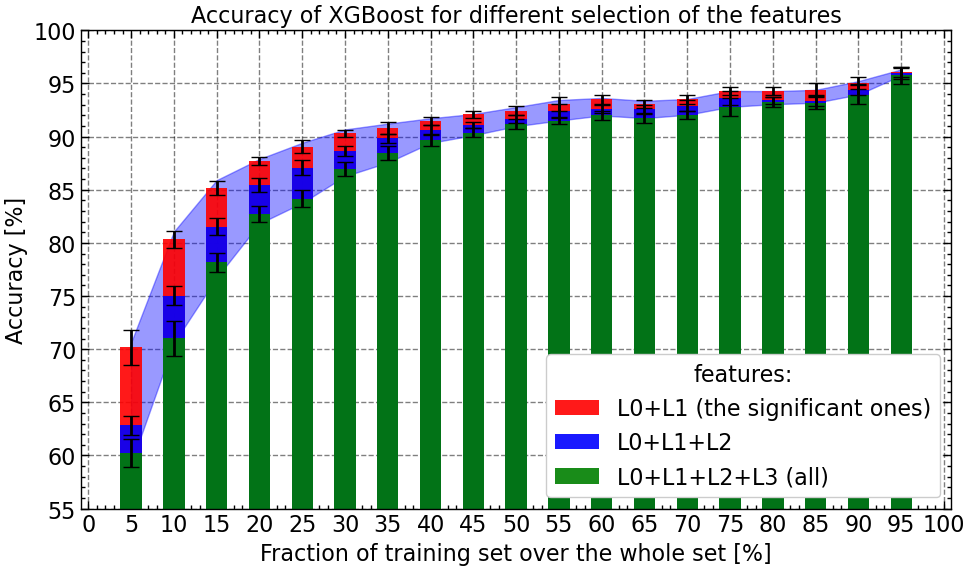

In [37]:
y_min = np.min(accuracy_generator.XGB_accuracies, axis = 0)[:,0]
y_max = np.max(accuracy_generator.XGB_accuracies, axis = 0)[:,0]

make_plot(np.array([accuracy_generator.XGB_accuracies[-1],
                    accuracy_generator.XGB_accuracies[-2],
                    accuracy_generator.XGB_accuracies[-3]]),
          title = "Accuracy of XGBoost for different selection of the features",
          width = 2.5,
          lim   = (55, 100),
          ths   = [y_min, y_max])

For each estimation of accuracy, the error bars represent the standard deviation of the accuracy evaluated over 10 distinct subsets of the training set.

As expected, the XGBoost algorithm trained with only the significant features (L0 + L1) consistently outperforms the model trained with all features, including noise (L0 + L1 + L2 + L3). The linearity of the improvement is evident in the intermediate case, where the model uses the two important features and one noise feature (L0 + L1 + L2), resulting in intermediate accuracy values. Notably, the gaps in accuracy between the maximum and the minimum dimensionality reduction are more pronounced with smaller training set sizes; however, as the training set size increases, the differences in accuracy tend to diminish.

## 3. XGBoost vs FFNN

In this paragraph, we compare the performance of XGBoost and a feed-forward neural network (FFNN) by computing the accuracy scores for both models. To evaluate the error bars, we perform cross-validation across 10 distinct subsets of the training set.

In [38]:
def runs():
    try:
        accuracy_generator.MLP_accuracies = pickle.load(open("MLP_accuracies.pkl", "rb"))
    except:
        mlp_1 = MLPClassifier(hidden_layer_sizes = (10),  # one hidden layers, 10 neurons
                              max_iter           = 1000,  # maximum number of iterations
                              random_state       = 42)    # seed
        #######################
        #
        mlp_2 = MLPClassifier(hidden_layer_sizes = (25),   # one hidden layers, 25 neurons
                              max_iter           = 1000,   # maximum number of iterations
                              random_state       = 42)     # seed
        #######################
        #
        mlp_3 = MLPClassifier(hidden_layer_sizes = (10, 10),   # two hidden layers, 10 neurons for each layer
                              max_iter           = 1000,
                              random_state       = 42)
        #######################
        #
        mlp_4 = MLPClassifier(hidden_layer_sizes = (18, 18),   # two hidden layers, 18 neurons for each layer
                              max_iter           = 1000,
                              random_state       = 42)
        #######################
        #
        mlp_5 = MLPClassifier(hidden_layer_sizes = (18, 25, 18),   # three hidden layers
                              max_iter           = 1000,
                              random_state       = 42)
        #######################
        #
        accuracy_generator(mlp_1, scale = True)
        accuracy_generator(mlp_2, scale = True)
        accuracy_generator(mlp_3, scale = False)
        accuracy_generator(mlp_4, scale = False)
        accuracy_generator(mlp_5, scale = False)
        #
        pickle.dump(accuracy_generator.MLP_accuracies, open("MLP_accuracies.pkl", "wb"))
    #####
#####

runs()

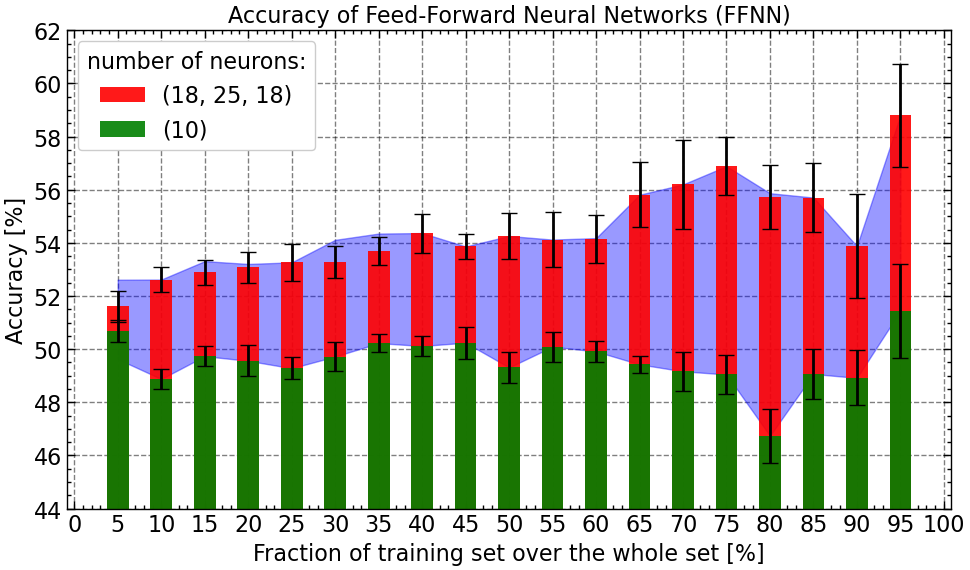

In [39]:
y_min = np.min(accuracy_generator.MLP_accuracies, axis = 0)[:,0]
y_max = np.max(accuracy_generator.MLP_accuracies, axis = 0)[:,0]

make_plot(np.array([accuracy_generator.MLP_accuracies[-1], accuracy_generator.MLP_accuracies[-5]]),
          "Accuracy of Feed-Forward Neural Networks (FFNN)",
          width = 2.5,
          lim = (44, 62),
          ths = [y_min, y_max])

This graph displays the accuracy of Feed-Forward Neural Networks (FFNN). Each error bar represents the standard deviation of a set of ten accuracy scores, each computed using different compositions of the training set. The performance of the network is evaluated across five configurations, each obtained varying numbers of layers and neurons:

- $(10)$: one layer of $10$ neurons;
- $(25)$: one layer of $25$ neurons;
- $(10, 10)$: two layers of $10$ neurons each;
- $(18, 18)$: two layers of $18$ neurons each;
- $(18, 25, 18)$: three layers with $18$, $25$, and $18$ neurons, respectively.

These configurations spread within the filled (blue) area of the graph. The models with the fewest $(10)$ and the most $(18, 25, 18)$ neurons are shown. As observed, the FFNN consistently fails to achieve 60% accuracy, fluctuating around $50 \% \div 53 \%$.

In [41]:
accuracy_generator(XGBClassifier_maker(), scale = True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:24<00:00,  1.26s/it]


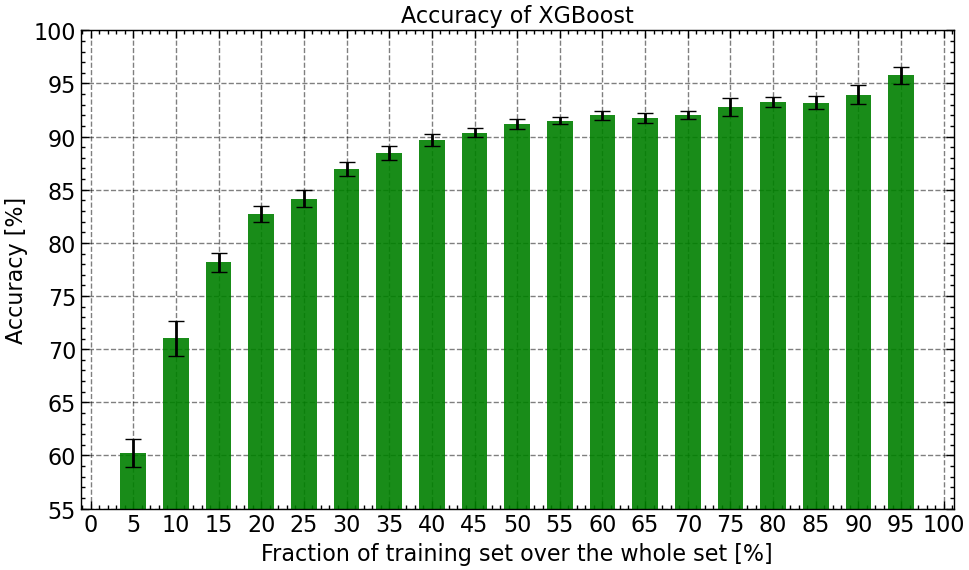

In [42]:
make_plot(np.array(accuracy_generator.XGB_accuracies)[-1],
          title = "Accuracy of XGBoost",
          width = 3,
          lim   = (55, 100),
          ths   = None)

This graph presents again the accuracy of XGBoost for comparison with the FFNN. The performance of the XGBoost model is significantly better at both high and low training set sizes. Even at the lowest fraction of the training set ($10 \% \div 20 \%$ of the entire dataset), XGBoost outperforms the FFNN considerably: $20$ to $35$ percentage points higher than that of the FFNN for the same size of the training set.

## ??

##### T-test evualuation
To evaluate the different dataset with less features compatiblity we use the t-test to verify the agreableness beteween eachother:
- **Null Hypothesis** Reduced feature sets perform equally well as the full feature set.
- **Interpretation**
A p-value < 0.05 rejects the null hypothesis, indicating a statistically significant difference in performance.

In [ ]:
for name in ["Exclude 1 Least", "Exclude 2 Least"]:
    t_stat, p_value = ttest_ind(
        results["All Features"]['all_scores'],
        results[name]['all_scores']
    )
    print(f"\nAll Features vs {name}:")
    print(f"p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("Difference is statistically significant (p < 0.05)")
    else:
        print("No significant difference (p ≥ 0.05)")

- The measurements are consistent with each other, indicating that the XGBoost-trained model performs well both in the presence and absence of error.  
- It is noticeable that removing one of the features (L2 or L3) improves the algorithm's performance.
- **capire come mai con solo L1 performa male (secondo me è successo qualcosa di strano qui sto risultato non mi convince)**